## Vanilla MobileNet Implementation

**AIM: Build and train an image classifier to detect images from different animal species using a Custom MobileNet Model in TensorFlow.**

### Objectives

- Data visualisation
- Data preprocessing and image augmentation
- Replicate the ResNet-34 architecture for model development.
- Compile and train the model
- Add early stopping callback (optional
- Save and load the model
- Model evaluation.
- Make predictions on new data using the trained model.

### Pre-requisite
- Google collaboratry or Jupyter Notebook
- animal-image-classification-dataset
- TensorFlow2

In [1]:
# Basic imports
import os
import sys
import random
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib

2026-01-25 20:07:29.430453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set seed for reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Check CPU availability
!nvidia-smi

Sun Jan 25 20:07:31 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro RTX 4000                Off |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P5              9W /  110W |       6MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Check number of GPUs

gpus = tf.config.list_physical_devices("GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Check TensorFlow version
print("TensorFlow Version", tf.__version__)

TensorFlow Version 2.20.0


In [6]:
# Set training data directory
base_dir = "../dataset/animal_image_classification_dataset"
base_dir = pathlib.Path(base_dir)

base_dir

PosixPath('../dataset/animal_image_classification_dataset')

In [7]:
# Training directory
train_dir = base_dir / "Training Data" / "Training Data"
train_dir

PosixPath('../dataset/animal_image_classification_dataset/Training Data/Training Data')

In [8]:
# Validation directory
validation_dir = base_dir / "Validation Data" / "Validation Data"
validation_dir

PosixPath('../dataset/animal_image_classification_dataset/Validation Data/Validation Data')

In [9]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 64
EPOCHS = 300

In [10]:
# Load the dataset

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    seed=SEED,
)

Found 30000 files belonging to 15 classes.


I0000 00:00:1769368053.220615  105754 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6624 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:01:00.0, compute capability: 7.5


In [11]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    seed=SEED,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 2000 files belonging to 15 classes.


In [12]:
class_names = train_dataset.class_names
class_names

['Beetle',
 'Butterfly',
 'Cat',
 'Cow',
 'Dog',
 'Elephant',
 'Gorilla',
 'Hippo',
 'Lizard',
 'Monkey',
 'Mouse',
 'Panda',
 'Spider',
 'Tiger',
 'Zebra']

In [13]:
# Number of classes
number_classes = len(class_names)
print("Total number of classes: ", number_classes)

Total number of classes:  15


### Sannity Check
**Confirms correct labels for images, detects corrupt images and verifies colour channels, orientation and resolution of images**

In [14]:
# This captures exactly one batch from the dataset
train_dataset.take(1)


<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
# Capture exactly one batch and store it in memory.
# This freezes the random augmentation for this specific set of images
for images, labels in train_dataset.take(1):
    fixed_images = images.numpy()
    fixed_labels = labels.numpy()

2026-01-25 20:07:34.680658: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


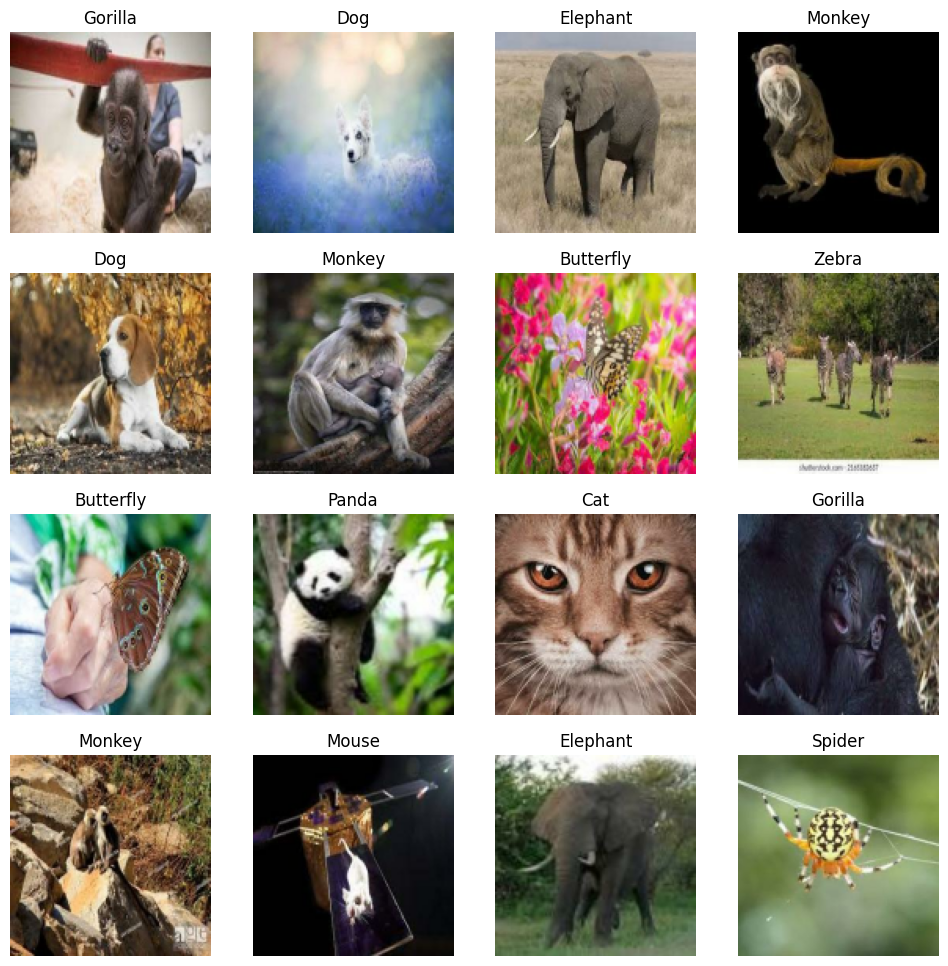

In [16]:
# Visualisation
# No matter how many times you run this cell, the images won't change
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(fixed_images[i].astype("uint8"))
    plt.title(class_names[fixed_labels[i]])
    plt.axis("off")

### Performance Optimisation using Autotune

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    .cache()
    .shuffle(1000)
    .prefetch(buffer_size=AUTOTUNE)
)

In [18]:
validation_dataset = (
    validation_dataset
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

### Vanilla MobileNet Implementation

In [19]:
# # Data augmentation

# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("hotizontal"),
#     tf.keras.layers.RandomRotation(0.2),
#     tf.keras.layers.RandomZoom(0.1)
# ])

In [20]:
# Import dependencies for MobileNet
import tensorflow as tf

In [21]:
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH) + (3,)
INPUT_SHAPE

(128, 128, 3)

In [22]:
# Define the MobileNet Model Function

def mobilenet(input_shape, number_classes):

    # Input Layer
    inputs = tf.keras.Input(shape=input_shape)

    # Define the Convolutional Layers
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Depthwise Separable Convolutional Layers
    
    # Depthwise Conv Layer 1
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    # Pointwise Conv Layer 1
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    for _ in range(5):
        x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
    
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters=1024, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Output Layer
    outputs = tf.keras.layers.Dense(number_classes, activation='softmax')(x)

    # Create the Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [23]:
# Create the MobileNet model
model = mobilenet(INPUT_SHAPE, number_classes)


In [24]:
# Print Model Summary 
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 64, 64, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 32, 32, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 32, 32, 128)    │         1,280 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,255,183 (12.42 MB)

 Trainable params: 3,233,295 (12.33 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [25]:
!pip show pydot

Name: pydot
Version: 1.4.2
Summary: Python interface to Graphviz's Dot
Home-page: https://github.com/pydot/pydot
Author: Ero Carrera
Author-email: ero.carrera@gmail.com
License: MIT
Location: /home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages
Requires: pyparsing
Required-by: apache-beam


In [26]:
!pip show graphviz

Name: graphviz
Version: 0.20.3
Summary: Simple Python interface for Graphviz
Home-page: https://github.com/xflr6/graphviz
Author: Sebastian Bank
Author-email: sebastian.bank@uni-leipzig.de
License: MIT
Location: /home/agbor/anaconda3/envs/tf/lib/python3.11/site-packages
Requires: 
Required-by: catboost


In [27]:
# tf.keras.utils.plot_model(
#     model,
#     to_file="Vanilla_MobileNet_architecture.png",
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir="TB"
# )

In [28]:
# Compile Model
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss=loss_function,
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [29]:
# Configure Callbacks

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="models/vanilla_mobilenet_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,
    factor=0.3,
    verbose=1
)

callbacks = [model_checkpoint, early_stopping, reduce_learning_rate]


In [30]:
# Train the Model to learn patterns from the image

history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=EPOCHS,
                    callbacks=callbacks)

Epoch 1/300


2026-01-25 20:07:56.310435: I external/local_xla/xla/service/service.cc:163] XLA service 0x7eba9800b7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-25 20:07:56.310452: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro RTX 4000, Compute Capability 7.5
2026-01-25 20:07:56.635000: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-25 20:07:58.737833: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90501


  3/469 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - accuracy: 0.0573 - loss: 2.8683 

I0000 00:00:1769368089.349130  105882 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1036 - loss: 2.7889
Epoch 1: val_accuracy improved from None to 0.05000, saving model to models/vanilla_mobilenet_model.keras

Epoch 1: finished saving model to models/vanilla_mobilenet_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 83ms/step - accuracy: 0.1197 - loss: 2.6986 - val_accuracy: 0.0500 - val_loss: 2.7253 - learning_rate: 0.0010
Epoch 2/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1681 - loss: 2.5268
Epoch 2: val_accuracy improved from 0.05000 to 0.16050, saving model to models/vanilla_mobilenet_model.keras

Epoch 2: finished saving model to models/vanilla_mobilenet_model.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.1839 - loss: 2.4909 - val_accuracy: 0.1605 - val_loss: 2.7158 - learning_rate: 0.0010
Epoch 3/300
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2248 - loss: 2.3727
Epoch 3: val_accuracy improved from 0.16050 to 0.19250, saving model to models/vanilla_mobilenet_model.

In [31]:
def plot_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(len(acc))


    plt.figure(figsize=(18, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()


In [32]:
loss, accuracy = model.evaluate(validation_dataset)

print(f"Model Loss: {loss:.2f}")
print(f"Model Accuracy: {accuracy:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4485 - loss: 1.7787
Model Loss: 1.78
Model Accuracy: 0.45
